# Proyección de Estructuras Minimizadas

In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
import pytraj as pyt
sys.path.append(r'..')

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
prot_name = 'cdk2'
# Este es el DF que no tiene aun afgregados los valores AUC de las conformaciones
path_string = '../data/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS_AUC_docking.json'.split('/')
path_to_json_file = glob.glob((os.path.join(*path_string)))[0]
                      
df_prot = pd.read_json(path_to_json_file)

### Carga de las estructuras Minimizadas

In [3]:
# Carga de la trayectoria de estructuras cristalograficas
path_min_directory = '../../ARCHIVOS/CRISTALES/PROT_CDK2_PREPARADAS/MIN/MIN_OUTS'.split('/')
files_pdb_min_struc = glob.glob(os.path.join(*path_min_directory) + '/*pdb')
# Ordenamso la lista de archivos
files_pdb_min_struc.sort()

In [4]:
from modules.subsecuencias_cdk2 import *
pisiani_residues = get_pisani_residues(sep=",")
mask_pisani = ':' + pisiani_residues + '@CA'

In [5]:
import pytraj as pyt
_itraj_minimized = pyt.iterload(files_pdb_min_struc, top = files_pdb_min_struc[0])

# Selección de los lso carbonos alfa de los residuos de Pisani
traj_minimized = _itraj_minimized[mask_pisani]
traj_minimized

pytraj.Trajectory, 402 frames: 
Size: 0.001051 (GB)
<Topology: 117 atoms, 117 residues, 117 mols, PBC with box type = truncoct>
           

### Carga de latrayectoria de Referencia (Cristalográfica)

In [6]:
path_to_crystal_traj = '../../ARCHIVOS/CRISTALES/TRAJ_CRISTALS_PDB/PDB_402_cdk2_PISANI_ALL.pdb'.split('/')
file_pdb_traj_pisani = os.path.join(*path_to_crystal_traj)
# Por ahora cargamos tods los átomos, sumiendo que en algun momento necesitaremos todos los átomos
traj_crystals = pyt.load(file_pdb_traj_pisani)
traj_crystals = traj_crystals.superpose()[mask_pisani]
traj_crystals

pytraj.Trajectory, 402 frames: 
Size: 0.001051 (GB)
<Topology: 117 atoms, 117 residues, 117 mols, non-PBC>
           

### Carga del cMDS con las estructuras Cristalogŕaficas

In [7]:
# Carga del objeto cMDS de las 402 estructuras cristalográficas
import pickle
path_mds_obj = os.path.join('..', 'data', 'trajectory_analysis', 'cMDS_Pisani_402_obj.pyobj')
#
with open(path_mds_obj, 'rb') as f:
    mds_pisani_402 = pickle.load(f)

### Proyección de las estructuras minimizadas en el espacio 

In [8]:
from modules.MDS import cMDS_proj
from miscellanious_traj_functions import get_sup_points_projected_mds

Usamos la función `get_sup_points_projected_mds` que previemente habíamos definido, por ahora se ha guardado el archivo con esta  función en el mismo directorio de este notebook.

In [9]:
help(get_sup_points_projected_mds)

Help on function get_sup_points_projected_mds in module miscellanious_traj_functions:

get_sup_points_projected_mds(MDS_ref_object, traj_reference, traj_out_of_sample, ref=0, n_components=2)
    Obtain the D-suplementary RMSD matrix of a suplementary trajectory and 
    perfroms cMDS projection of out of sample points by using get_sup_rmsd_pairwise() function.
    
    Parameters:
        MDS_ref_object (MDS object): cMDS object.
        traj_reference (pytraj.trajectory): pytraj Trajectory object with m frames and sliced atoms
        traj_out_of_sample: pytraj Trajectory object with n frames sliced atoms
        ref (int):  number of conformations inside traj_reference to use 
                    as reference to superpose traj_out_of_sample
        n_vects (int): Number of mds eigenvectors to return
    Returs:
        mds_projected (numpy narray): n_vects mds eigenvectors



In [10]:
projected_points = get_sup_points_projected_mds(MDS_ref_object = mds_pisani_402,
                             traj_reference = traj_crystals,
                             traj_out_of_sample = traj_minimized)

## Visualización

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'talk', style = 'white')
from modules.plotting_functions import plot_points, plot_anotation_labels

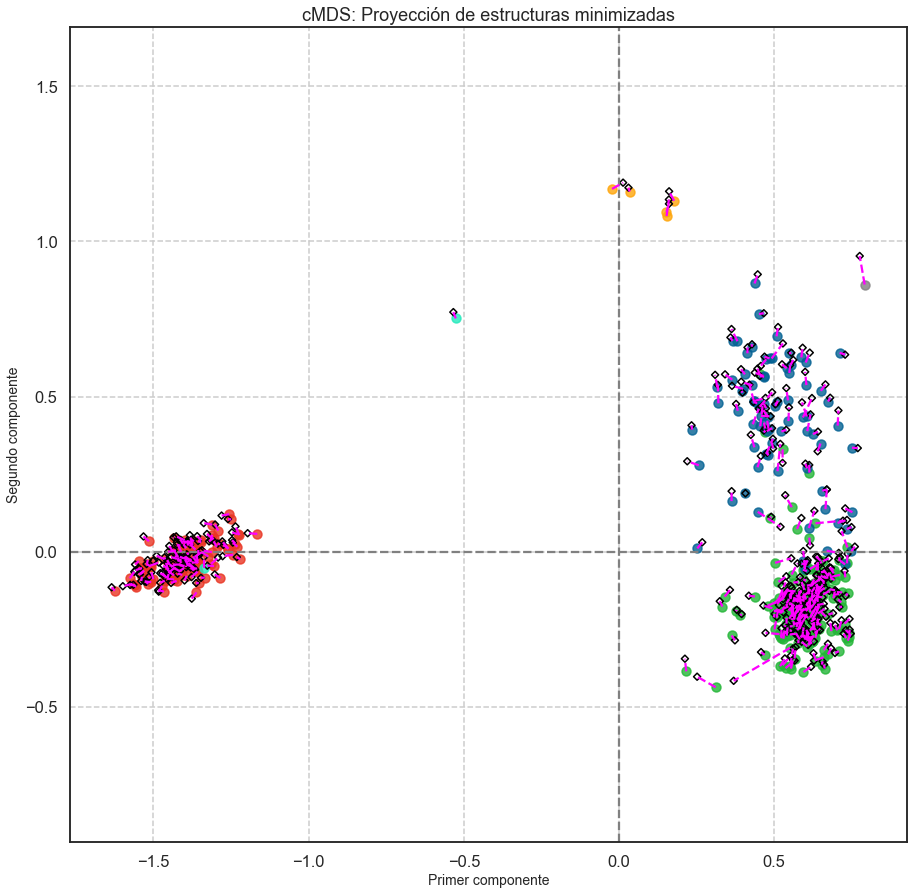

In [38]:
# Se genera la gráfica de ejmplo de proyección
fig = plt.figure(figsize=(15, 15))
plot_points(mds = mds_pisani_402[0], labels = df_prot.Labels_conf, alpha=0.8,
                             title = "cMDS: Proyección de estructuras minimizadas", point_size = 80,
           )
# Proyección de los puntos "out of sample"
plt.scatter(projected_points[0], projected_points[1], marker = 'D', 
            c = 'None', edgecolors='black', s = 25);

n_confs = traj_crystals.n_frames
for i in range(n_confs):
    plt.plot([mds_pisani_402[0][0][i], projected_points[0][i]],
             [mds_pisani_402[0][1][i], projected_points[1][i]],  'r--', c='magenta')